# MuZero: Model-based RL (Part 1)

In previous notebooks, I introduced various Reinforcement Learning (RL) methods such as [Q-learning](https://medium.com/@ym1942/find-an-optimal-policy-with-finite-markov-decision-process-part3-td-learning-557245c9735c), [Deep Q-learning](https://medium.com/@ym1942/deep-q-learning-dqn-tutorial-with-cartpole-v0-5505dbd2409e), and [Actor-Critic](https://medium.com/@ym1942/policy-gradient-methods-from-reinforce-to-actor-critic-d56ff0f0af0a). These methods typically assume that the dynamics of the environment are known. In other words, we know how the environment changes when taking a certain action, the rewards obtained in each state, and when the episode terminates.

These RL methods, which do not require learning the environment's dynamics, are called model-free RL. They are model-free because the agent does not internally have or learn a model of the environment; the only goal is to learn the optimal policy through strategic interaction with the environment. This approach works when the environment's dynamics are defined and known. Board games such as Chess are examples of this, where we know exactly how the board changes with each move and the conditions for winning or losing.

However, in real-life scenarios, we often do not know the environment's dynamics and must learn them through interaction. For example, a walking robot must figure out how the environment changes by moving parts of its body in certain ways. This kind of knowledge about the environment is called a "dynamics model" in RL. Methods that learn a world "dynamics model" through interaction with the environment are called model-based reinforcement learning.

In this series of notebooks, we will learn one of such methods called Muzero developed by Google Deep Mind in 2020. Before Muzero, model-based algorithms did not enjoy success over model-free methods because:
- Dynamics models are difficult to learn.
- Errors in the dynamics model propagate over steps.
    - If a dynamics model makes a large prediction error, there will be a significant gap between the actual and predicted agent states, complicating policy learning.
- Environments with high-dimensional input spaces (e.g., images in Atari games) are difficult to learn.
    - Even small pixel changes can create different environment states, requiring the agent to learn numerous patterns.

MuZero is the first algorithm to solve these problems. It learns the dynamics model through interaction and uses it to learn the optimal action to take (i.e., policy).

Here is our roadmap to learn MuZero:
- Notebook 1: Self-play to collect training data (this notebook)
- Notebook 2: Network weight update
- Notebook 3: Integrate two components


### Muzero overview

Before diving into the main topic of this notebook (self-play to collect training data), let's briefly discuss the overview of MuZero to get the big picture.

As mentioned earlier, MuZero learns the dynamics model of the environment to learn the optimal policy. Specifically, MuZero utilizes three deep learning models:
- Representation function
- Dynamics function
- Prediction function

We will soon talk about what each model does but I would like to note one important thing - **a key difference between MuZero and traditional model-based methods is the use of latent states**. MuZero uses latent states derived from the actual states to efficiently learn the dynamics and optimal policy.

The representation function learns the mapping between the actual environment state and the latent state. The goal of this model is to extract a latent state that is helpful to accurately predict policies, values, and rewards. In other words, this function extracts key features of the environment relevant to policies, values, and rewards. Consider an Atari game environment where the input is a grid of pixels. In each frame, many pixel values change. However, changes in background pixels are less important than changes in pixels representing the main target or player. Traditional methods, which use the full input space to learn dynamics, must account for these irrelevant changes. In other words, the model has to learn the dynamics of the entire high-dimensional pixel images. With MuZero, the representation function extracts key features of the environment state, focusing on learning the dynamics related to them, making the learning process more efficient. The representation function receives the raw current state as input and returns the corresponding latent state.

The dynamics function learns how the environment changes using the latent state. It receives the current latent state and action, returning the predicted next latent state and the predicted immediate reward at the next latent state. Again, the key difference with MuZero is the use of latent state encoding useful features to predict policies, values, and rewards. The predicted next latent state from the dynamics function does not have any semantic meaning other than containing useful information for prediction.

The prediction function predicts the policy and value at a given latent state. It takes the latent state as input and outputs the predicted policy and value. After completing the model learning process, the predicted policy from this function is used when acting in the environment.

In summary, what these functions do is that:
1. The representation function extracts the latent state of the current state, including all key information about the environment to predict the value, reward, and policy.
2. Given the current latent state, the dynamics function is used to run a mental simulation to predict what will happen in the future if the agent takes a certain action from the current state.
3. The prediction function predicts the values and actions to take (policy) at each latent state while running the mental simulation with the dynamics function. The value and policy guide the mental simulation with the dynamics function.

Remember that when the environment dynamics are known, an agent can use it to run the mental simulation to see what will happen if it takes a certain action. These three models are used to run a mental simulation even when the environment dynamics are unknown. To fit these three models, we need to collect sample experiences. How should we do this? In this notebook, we focus on how to collect the training data to fit these three models.

### Monte Carlo Tree Search to collect training samples

MuZero uses Monte Carlo Tree Search (MCTS) to collect training samples through self-play. MCTS consists of four steps:
1. Selection: Traverse the current tree from the root node using the Upper Confidence Bound (UCB).
2. Expansion: Add a child node to the leaf node which is optimally reached through the selection process.
3. Simulation: Perform a random simulation from the expanded child node to a terminating state.
4. Backpropagation: Update the value of each ancestor node using the expected value.

For a more detailed introduction to MCTS, check [this page](https://www.geeksforgeeks.org/ml-monte-carlo-tree-search-mcts/).

MuZero modifies MCTS to work with latent states. Another difference is that instead of running a random simulation from the leaf node, MuZero uses bootstrapping, which employs the expected value at a node as the value estimate, similar to [TD-learning](https://medium.com/@ym1942/find-an-optimal-policy-with-finite-markov-decision-process-part3-td-learning-557245c9735c).

Let's see the implementation of this process step by step.

In [1]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display

import torch


### Prepare gym environment

In this series of notebooks, we utilize the CartPole-v0 environment in Gymnasium.

[Learn more about the CartPole-v0 environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

The goal of this environment is to balance a pole by applying forces in the left and right directions on the cart. It has a discrete action space:
- 0: Push cart to the left
- 1: Push cart to the right

Upon taking an action, either left or right, an agent observes a 4-dimensional state consisting of:
- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

A reward of +1 is granted to the agent at each step while the pole is kept upright. The maximum reward an agent can earn in a single episode is 200.

The episode ends under the following conditions:
- Termination: Pole Angle is greater than ±12°
- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Truncation: Episode length exceeds 200 steps

In the code below, I provide an example of the agent randomly exploring this environment over 20 time steps.


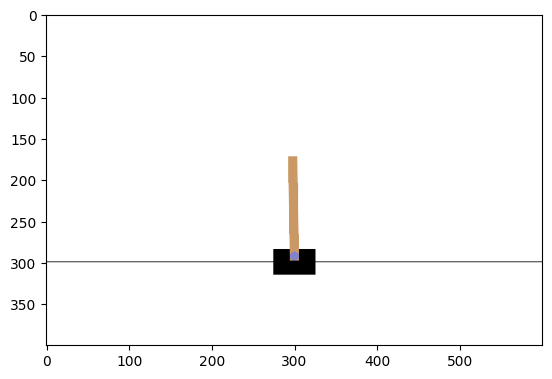

In [2]:
# Create CartPole environment
env = gym.make('CartPole-v0', render_mode='rgb_array')
state, _ = env.reset()

# Run the environment for 20 steps
for i in range(20):
    # Display the current state of the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # Choose a random action from the action space
    action = env.action_space.sample()
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, info = env.step(action)
    
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
env.close()


### Code overview for the training sample collection process

The below code shows the overview of the sample collection process by playing one game. MuZero iteratively runs the below code multiple times to collect experience over many games. In this notebook, we will learn 6 components of this code.

In [17]:
config = {
          # Simulation and environment Config
          'action_space_size': 2, # number of potential action
          'max_moves': 200, # max number of action in one game
          'num_simulations': 50, # number of MCTS simulation to perform at each root node
          'discount': 0.997, # value discount rate used with bootstrapping
          'min_value': 0,
          'max_value': 200,

          # Parameters to balance exploitation and exploration during MCTS
          'root_dirichlet_alpha': 0.1, # 
          'root_exploration_fraction': 0.25,

          # Upper Confidence Bound (UCB) hyperparameters (used in the MuZero paper)
          'pb_c_base': 19652,
          'pb_c_init': 1.25,
}

def play_game(network, env):
    """
    Plays one game
    network: network models used in MCTS unrolling
    env: gym environment
    """
    # Initialize environment
    start_state, _ = env.reset()

    # (1) Create Game Object to store game play log
    game = Game(config['action_space_size'], config['discount'], start_state)
    
    # Play a game using MCTS until game will be done or max_moves will be reached
    while not game.done and len(game.action_history) < config['max_moves']:
        # (2) Create Node Object to store information about the root node
        root = Node(0)
    
        # (3) Create MinMaxStats Object to normalize values
        min_max_stats = MinMaxStats(min_value, max_value)
        
        # (4) Expand the current root node
        curr_state = game.curr_state
        expand_root(root, list(range(config['action_space_size'])),
                    network, curr_state)
        
        # (5) Run MCTS
        run_mcts(config, root, network, min_max_stats)
        
        # (6) Select an action to take
        action = select_action(config, root, network)        

        # Take an action and store tree search statistics
        game.take_action(action, env)
        game.store_search_statistics(root)
    return game

### (1) Create a Game Object to store game play log

The first step is to create a Game class object to store logs of self-play. The data observed during self-play such as normalized visit count (i.e. visit probability) and expected value of the root node will be stored and used to train deep learning networks.

In [8]:
class Game:
    """
    A single episode of interaction with the environment.
    """
    def __init__(self, action_space_size, discount, curr_state):

        self.action_space_size = action_space_size
        self.curr_state = curr_state
        self.done = False
        self.discount = discount
        self.priorities = None

        self.state_history = [self.curr_state]
        self.action_history = []
        self.reward_history = []

        self.root_values = []
        self.child_visits = []

    def take_action(self, action, env):
        """
        Take an action and store the action, reward, and new state
        """
        observation, reward, terminated, truncated, _ = env.step(action)
        self.curr_state = observation
        self.action_history.append(action)
        self.reward_history.append(reward)
        self.done = terminated | truncated
        if not self.done:
            self.state_history.append(self.curr_state)

    def store_search_statistics(self, root):
        """
        Stores the search statistics for the root node
        """
        # Stores the normalized root node child visits (i.e. policy target)
        sum_visits = sum(child.visit_count for child in root.children.values())
        self.child_visits.append(np.array([
            root.children[a].visit_count
            / sum_visits if a in root.children else 0
            for a in range(self.action_space_size)
        ]))
        
        # Stores the root node value, computed from the MCTS (i.e. vlaue target)
        self.root_values.append(root.value())


### (2) Create a Node Object to store information about the root node

Next, we define a Node class to store information about each node during MCTS. This class object contains key attributes to represent each node, such as the total visit count, total value, and the hidden representation of the node. Below is the implementation.

In [9]:
class Node(object):
    
    def __init__(self, prior):
        """
        Node in MCTS
        prior: The prior policy on the node, computed from policy network
        """
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_representation = None
        self.reward = 0
        self.expanded = False

    def value(self):
        """
        Compute expected value of a node
        """
        if self.visit_count == 0:
            return 0
        else:
            return self.value_sum / self.visit_count

### (3) Create a MinMaxStats Object to normalize values

We also create a MinMaxStats class object to normalize the observed value. This class stores the max and min values of the environment to transform the observed value into a range between 0 and 1.

In [ ]:
class MinMaxStats(object):
    """
    Store the min-max values of the environment to normalize the values
    Max value will be 1 and min value will be 0
    """

    def __init__(self, minimum, maximum):
        self.maximum = maximum
        self.minimum = minimum

    def update(self, value: float):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value: float) -> float:
        if self.maximum > self.minimum:
            # We normalize only when we have set the maximum and minimum values.
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value

### (4) Expand the current root node

To start running MCTS, we first expand the root node. expand_root function runs initial_inference function, which uses representation and prediction functions to get the latent representation, predicted policy, and predicted value of the current root node. We will learn the detailed implementation of initial_inference function in the next notebook. 

The obtained results are stored in Node object representing the current root node. The obtained policy is used as the probability to choose each child node. MuZero uses a Dirichlet random variable to add some randomness to the prior probability of choosing each child. This randomness helps to explore different children during MCTC.

In [10]:
def expand_root(node, actions, network, current_state):
    """
    Expand the root node given the current state
    """
    # obtain the latent state of the root node by using representation and prediction functions
    observation = torch.tensor(current_state)
    transformed_value, reward, policy_logits, hidden_representation = network.initial_inference(observation)
    node.hidden_representation = hidden_representation
    node.reward = reward
    node.visit_count = 1
    node.value_sum = transformed_value

    # extract softmax policy and set node.policy
    softmax_policy = torch.nn.functional.softmax(torch.squeeze(policy_logits))
    node.policy = softmax_policy

    # instantiate node's children with prior values, obtained from the predicted policy
    for action, prob in zip(actions, softmax_policy):
        child = Node(prob)
        node.children[action] = child
    
    # add exploration noise
    actions = list(node.children.keys())
    noise = np.random.dirichlet([config['root_dirichlet_alpha']]*len(actions))
    frac = config['root_exploration_fraction']
    for a, n in zip(actions, noise):
        node.children[a].prior = node.children[a].prior * (1-frac) + n*frac

    # set node as expanded
    node.expanded = True
    

### (5) Run MCTS

run_mcts function is the main function to run MCTS. It mainly runs three steps:
1) Starting from the root node, expand the node based on Upper Confidence Bound score until reaching a node, which has not expanded yet (called a leaf node)
2) Expand the leaf node by using networks 
3) Perform backpropagation to update search statistics of each node upto the root node

In [11]:
def run_mcts(config, root, network, min_max_stats):
    """
    Run the main loop of MCTS for config['num_simulations'] simulations

    root: the root node
    network: the network
    min_max_stats: the min max stats object
    """
    for i in range(config['num_simulations']):
        history = []
        node = root
        search_path = [node]

        # 1. expand node until reaching the leaf node
        while node.expanded:
            action, node = select_child(config, node, min_max_stats)
            history.append(action)
            search_path.append(node)
        parent = search_path[-2]
        action = history[-1]
        
        # 2. expand the leaf node
        value = expand_node(node, list(
            range(config['action_space_size'])), network, parent.hidden_representation, action)
        
        # 3. perform backpropagation
        backpropagate(search_path, value,
                    config['discount'], min_max_stats)
        

#### (5)-1. Select child

Until reaching the leaf node, select_child function chooses a child with the maximum Upper Confidence Bounds (UCB) score to expand the current node. For more detail on the UCB score, please refer to [Appendix B of the MuZero paper](https://arxiv.org/pdf/1911.08265#page=14.33). 

In [12]:
def select_child(config, node, min_max_stats):
    """
    Select a child at an already expanded node
    Selection is based on the UCB score
    """
    best_action, best_child = None, None
    ucb_compare = -np.inf
    for action,child in node.children.items():
        ucb = ucb_score(config, node, child, min_max_stats)
        if ucb > ucb_compare:
            ucb_compare = ucb
            best_action = action # action, int
            best_child = child # node object
    return best_action, best_child


def ucb_score(config, parent, child, min_max_stats):
    """
    Compute UCB Score of a child given the parent statistics
    """
    pb_c = np.log((parent.visit_count + config['pb_c_base'] + 1)
                / config['pb_c_base']) + config['pb_c_init']
    pb_c *= np.sqrt(parent.visit_count) / (child.visit_count + 1)

    prior_score = pb_c*child.prior.detach().numpy()
    if child.visit_count > 0:
        value_score = min_max_stats.normalize(
            child.reward + config['discount']*child.value())
    else:
        value_score = 0
    return prior_score + value_score
    

#### (5)-2. Expand node

After reaching the leaf node, expand_node function expands the leaf node. It uses recurrent_inference function, which leverages dynamics and prediction functions to obtain the predicted reward, policy, value, and next latent state. The obtained outputs are used to register the information about the leaf node and children nodes. We will learn the detailed implementation of recurrent_inference function in the next notebook. 

In [13]:
def expand_node(node, actions, network, parent_state, parent_action):
    """
    Expand a leaf node given the parent state and action
    """
    # run recurrent inference at the leaf node
    transformed_value, reward, policy_logits, hidden_representation = network.recurrent_inference(parent_state, parent_action)
    node.hidden_representation = hidden_representation
    node.reward = reward

    # compute softmax policy and store it to node.policy
    softmax_policy = torch.nn.functional.softmax(torch.squeeze(policy_logits))
    node.policy = softmax_policy

    # instantiate node's children with prior values, obtained from the predicted softmax policy
    for action, prob in zip(actions,softmax_policy):
        child = Node(prob)
        node.children[action] = child

    # set node as expanded
    node.expanded = True
    
    return transformed_value
        

#### (5)-3. Backpropagation

After expanding the leaf node, MuZero runs backpropagation. In backward order, it updates the node statistics (total visit count and total value) of each node upto the root node. The discount rate is used to compute the discounted value. 

In [14]:
def backpropagate(path, value, discount, min_max_stats):
    """
    Update a discounted total value and total visit count
    """
    for node in reversed(path):
        node.visit_count += 1
        node.value_sum += value 
        min_max_stats.update(node.value())
        value = node.reward + discount * value

### (6) Select and take an action from the root

After performing multiple self-play simulations from the root node with run_mcts function, MuZero chooses the actual action to take to move to the next state. It chooses the action based on the visit count of each child. During a network training phase, it chooses action stochastically. During a test phase, it chooses action deterministically based on argmax policy.

In [15]:
def select_action(config, node, test=False):
    """
    Select an action to take
    train mode: action selection is performed stochastically
    test mode: action selection is performed deterministically (argmax)
    """
    visit_counts = [
        (child.visit_count, action) for action, child in node.children.items()
    ]
    if not test:
        action = softmax_sample(visit_counts, 1)
    else:
        action = softmax_sample(visit_counts, 0)
    return action


def softmax_sample(visit_counts, temperature):
    """
    Sample an action
    """
    counts_arr = np.array([c[0] for c in visit_counts])
    if temperature == 0: # argmax
        action_idx = np.argmax(counts_arr)
    else:
        numerator = np.power(counts_arr, 1/temperature)
        denominator = np.sum(numerator)
        dist = numerator / denominator
        action_idx = np.random.choice(np.arange(len(counts_arr)), p=dist)

    return action_idx

### Summary

In this notebook, we learned how MuZero collects training samples with self-play using Monte Carlo Tree Search. In the next notebook, we will learn the details of deep learning models used in MuZero.